# Notebook 25: Chapter 6 Figures

This notebook performs a segmentation workflow adapted from NB 11 & 22.
The F50 sand experiment F63 is used to generate figures to be used in Chapter
6 of Gus's thesis.

# Import packages

In [1]:
# Standard library imports
from pathlib import Path
# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
from scipy import signal
from skimage import color, measure, segmentation
# Local module imports
from segmentflow import segment, view, mesh
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load full data

Loading images...
--> Images loaded as 3D array:  (150, 1024, 1004)
Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [0, 99.9]...
--> Preprocessing complete.
Plotting images: [49, 74, 99]


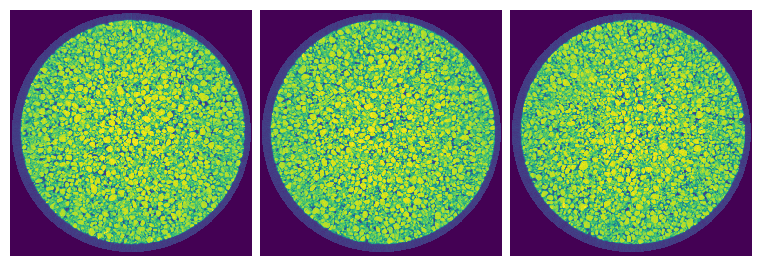

In [2]:
ums_per_pixel = 13.84
# Load images as 3D array from a directory containing images.
imgs = segment.load_images(
    Path('../data/F63tiff/'),
    slice_crop=[400, 550],
    file_suffix='tiff'
)
slices = [49, 74, 99]
imgs_pre = segment.preprocess(
    imgs, median_filter=True, rescale_intensity_range=[0, 99.9]
)
fig, axes = view.plot_slices(imgs_pre, slices=slices)
plt.show()

## Load cropped data

Passing `slice_crop`, `row_crop`, and `col_crop` to only load part of the dataset

Loading images...
--> Images loaded as 3D array:  (150, 150, 150)
Plotting images: [49, 74, 99]


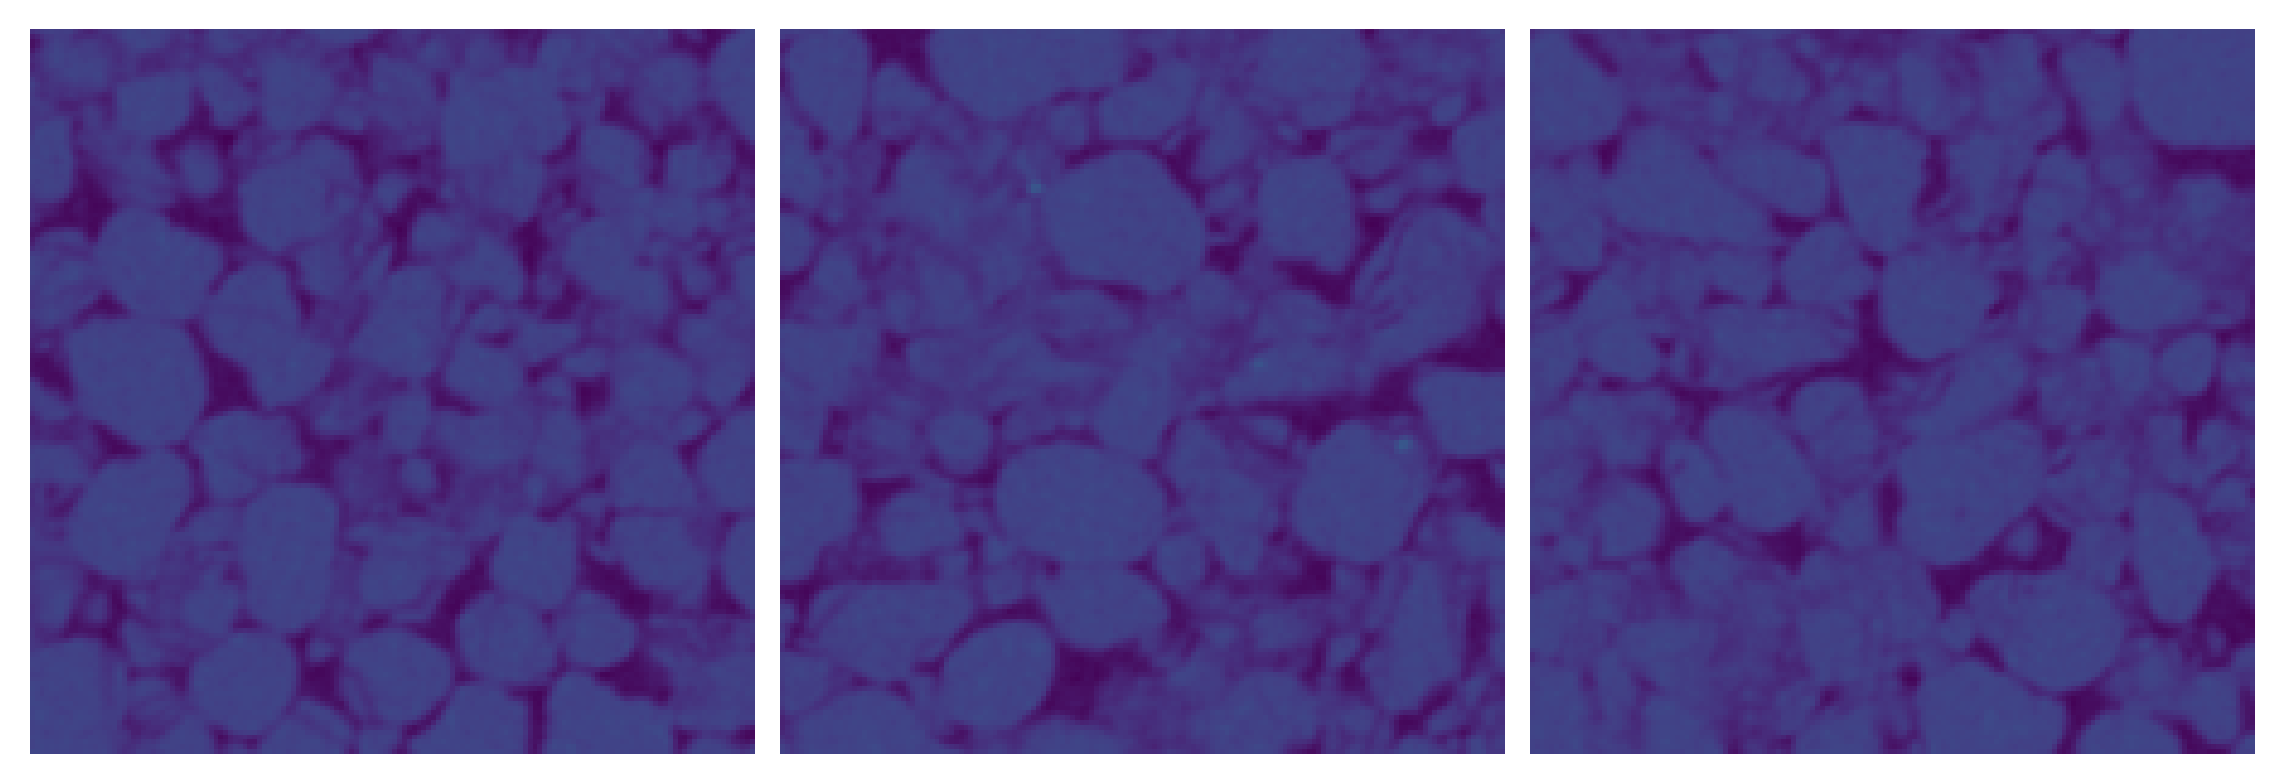

In [3]:
ums_per_pixel = 13.84
# Load images as 3D array from a directory containing images.
imgs = segment.load_images(
    Path('../data/F63tiff/'),
    slice_crop=[400, 550],
    row_crop=[400, 550],
    col_crop=[400, 550],
    file_suffix='tiff'
)
slices = [49, 74, 99]
fig, axes = view.plot_slices(imgs, slices=slices, dpi=300)

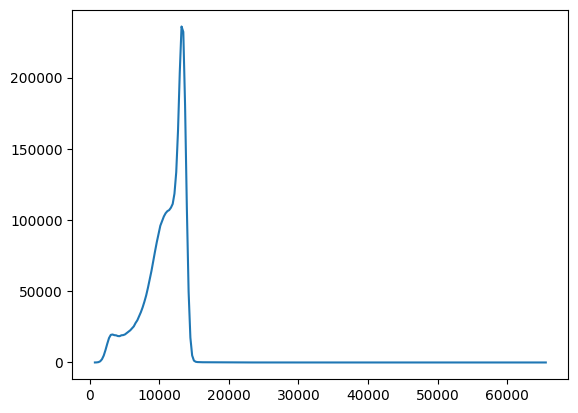

In [4]:
hist, bin_edges = np.histogram(imgs, bins=256)
fig, ax = plt.subplots()
ax.plot(bin_edges[1:], hist)
plt.show()

## Preprocess data

Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [0, 99.9]...
--> Preprocessing complete.
Plotting images: [49, 74, 99]


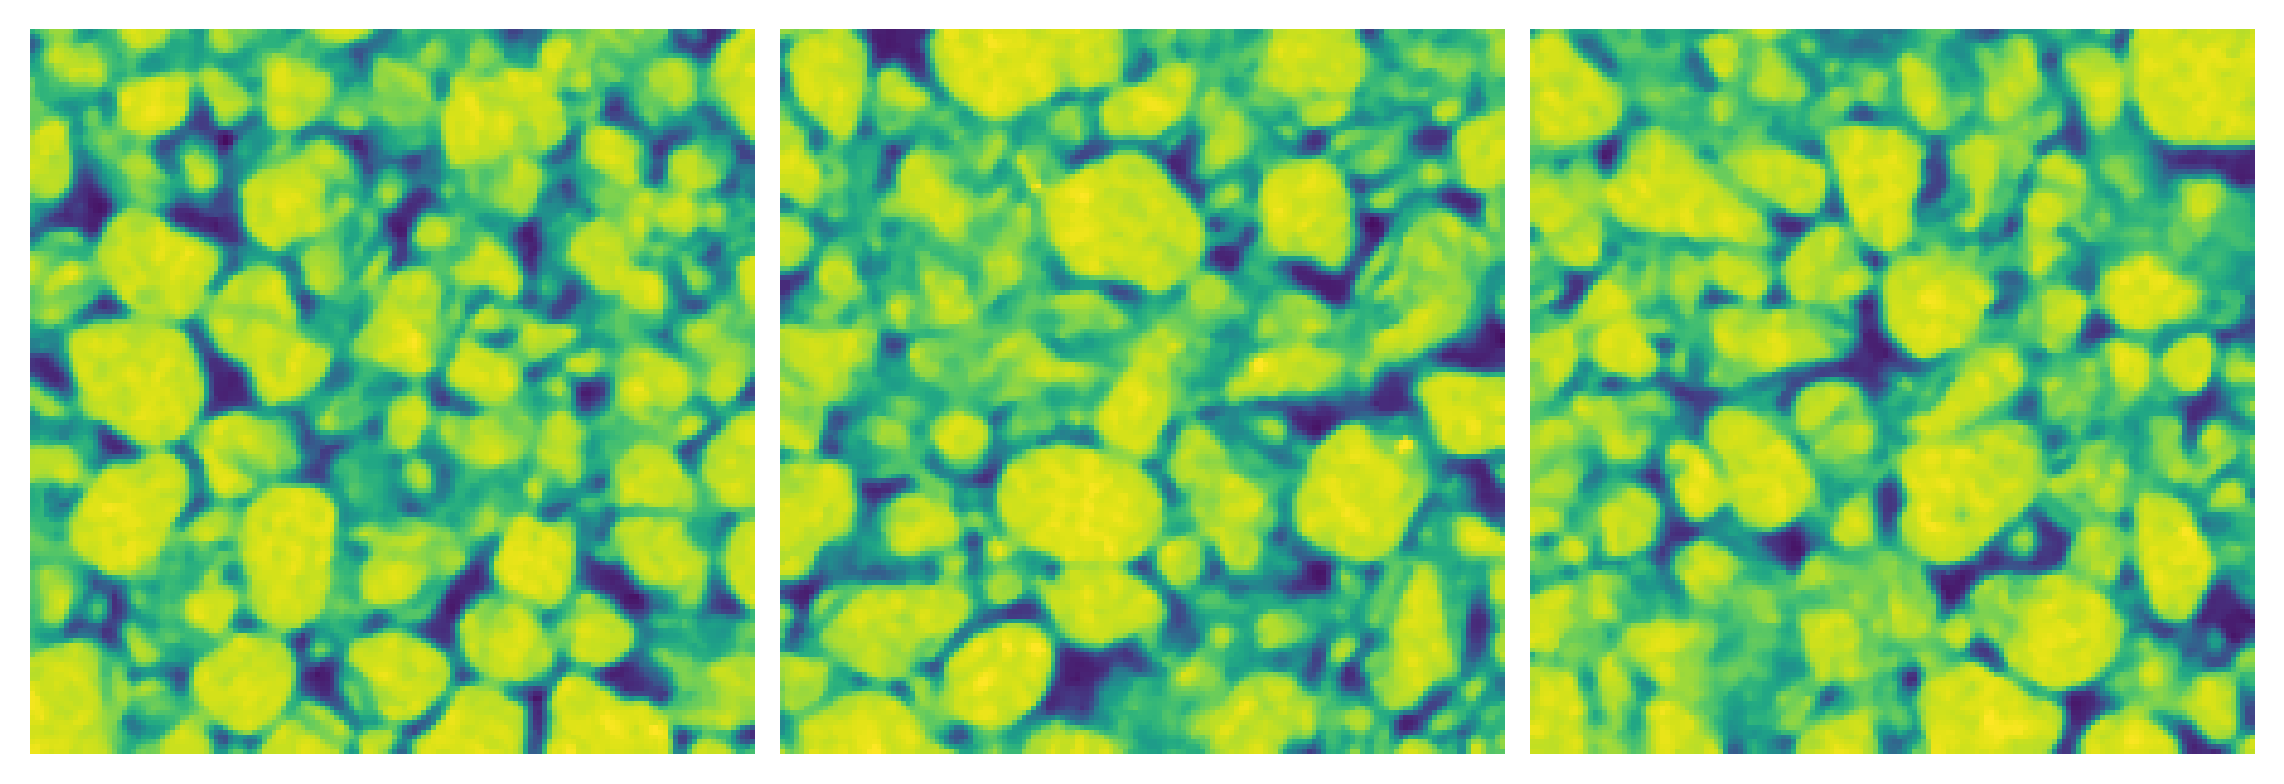

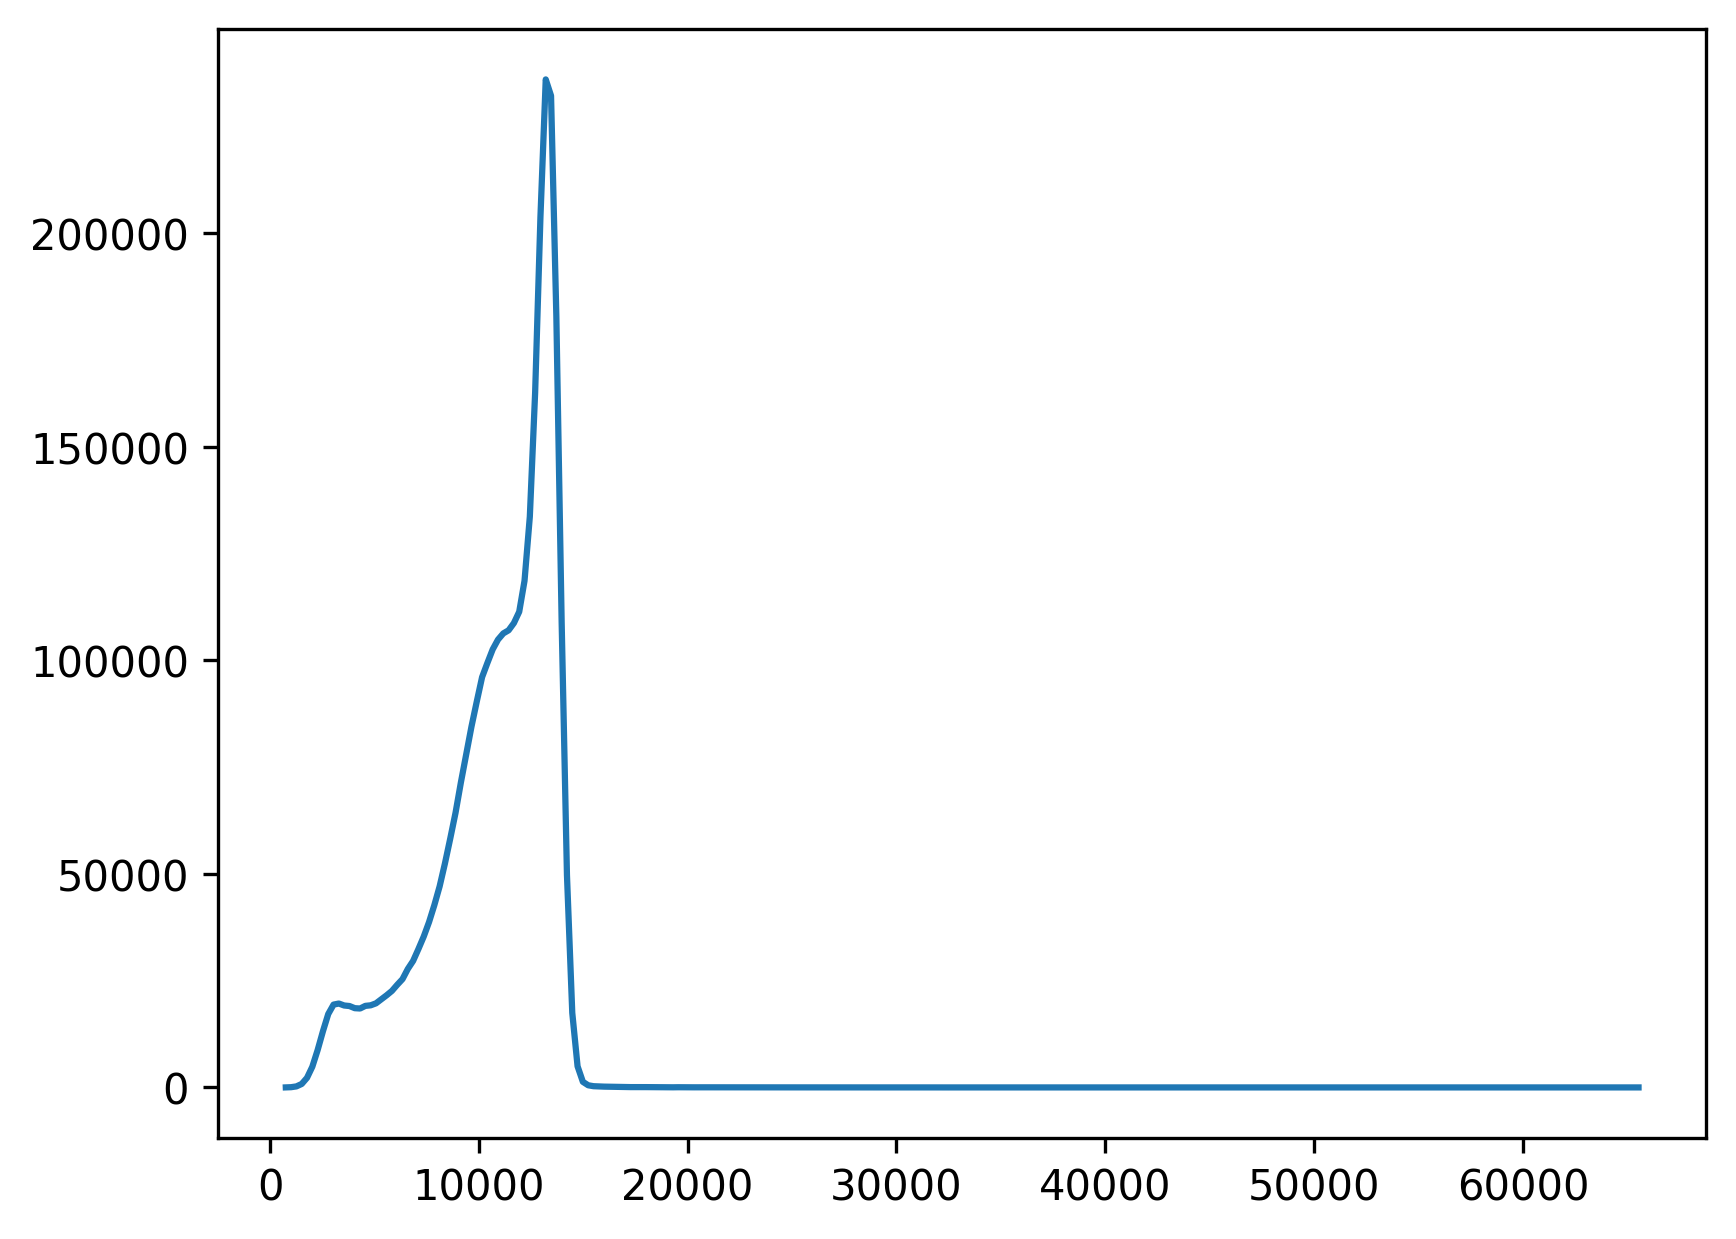

In [5]:
imgs_pre = segment.preprocess(
    imgs, median_filter=True, rescale_intensity_range=[0, 99.9]
)
fig, axes = view.plot_slices(imgs_pre, slices=slices, dpi=300)
fig, ax = plt.subplots(dpi=300)
hist, bin_edges = np.histogram(imgs, bins=256)
ax.plot(bin_edges[1:], hist)
plt.show()

--> 3 peak(s) found: [11796.300000000001, 47840.55, 59636.85]
--> 2 min(s) found: [12451.65, 51117.3]


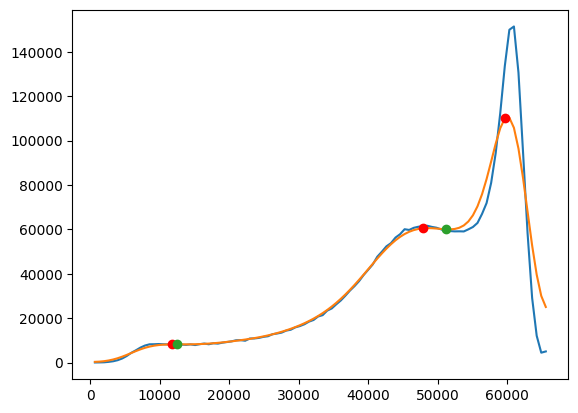

In [6]:
fig, ax = plt.subplots()
nbins = 100
# Calculate histogram
hist, bins = np.histogram(imgs_pre, bins=nbins)
ax.plot(bins[1:], hist)
# Smooth histogram with Gaussian filter
hist_smooth = ndi.gaussian_filter(hist, 3)
ax.plot(bins[1:], hist_smooth, c='C1')
# Find local maxima in smoothed histogram
peak_inds, peak_props = signal.find_peaks(hist_smooth)
peaks = [bins[i] for i in peak_inds]
print(f'--> {len(peaks)} peak(s) found: {peaks}')
for i, val in zip(peak_inds, peaks):
    ax.scatter(val, hist_smooth[i], color='red', zorder=2)
# Find minima between each neighboring pair of local maxima
min_inds = []
for i in range(1, len(peak_inds)):
    min_sub_i = np.argmin(hist_smooth[peak_inds[i - 1] : peak_inds[i]])
    min_inds.append(min_sub_i + peak_inds[i - 1])
mins = [bins[i] for i in min_inds]
print(f'--> {len(mins)} min(s) found: {mins}')
for i, val in zip(min_inds, mins):
    ax.scatter(val, hist_smooth[i], color='C2', zorder=2)
plt.show()

n_vox_binder=1669941
n_vox_grains=1616107
n_vox_nonvoid=3286048
Plotting images: [49, 74, 99]


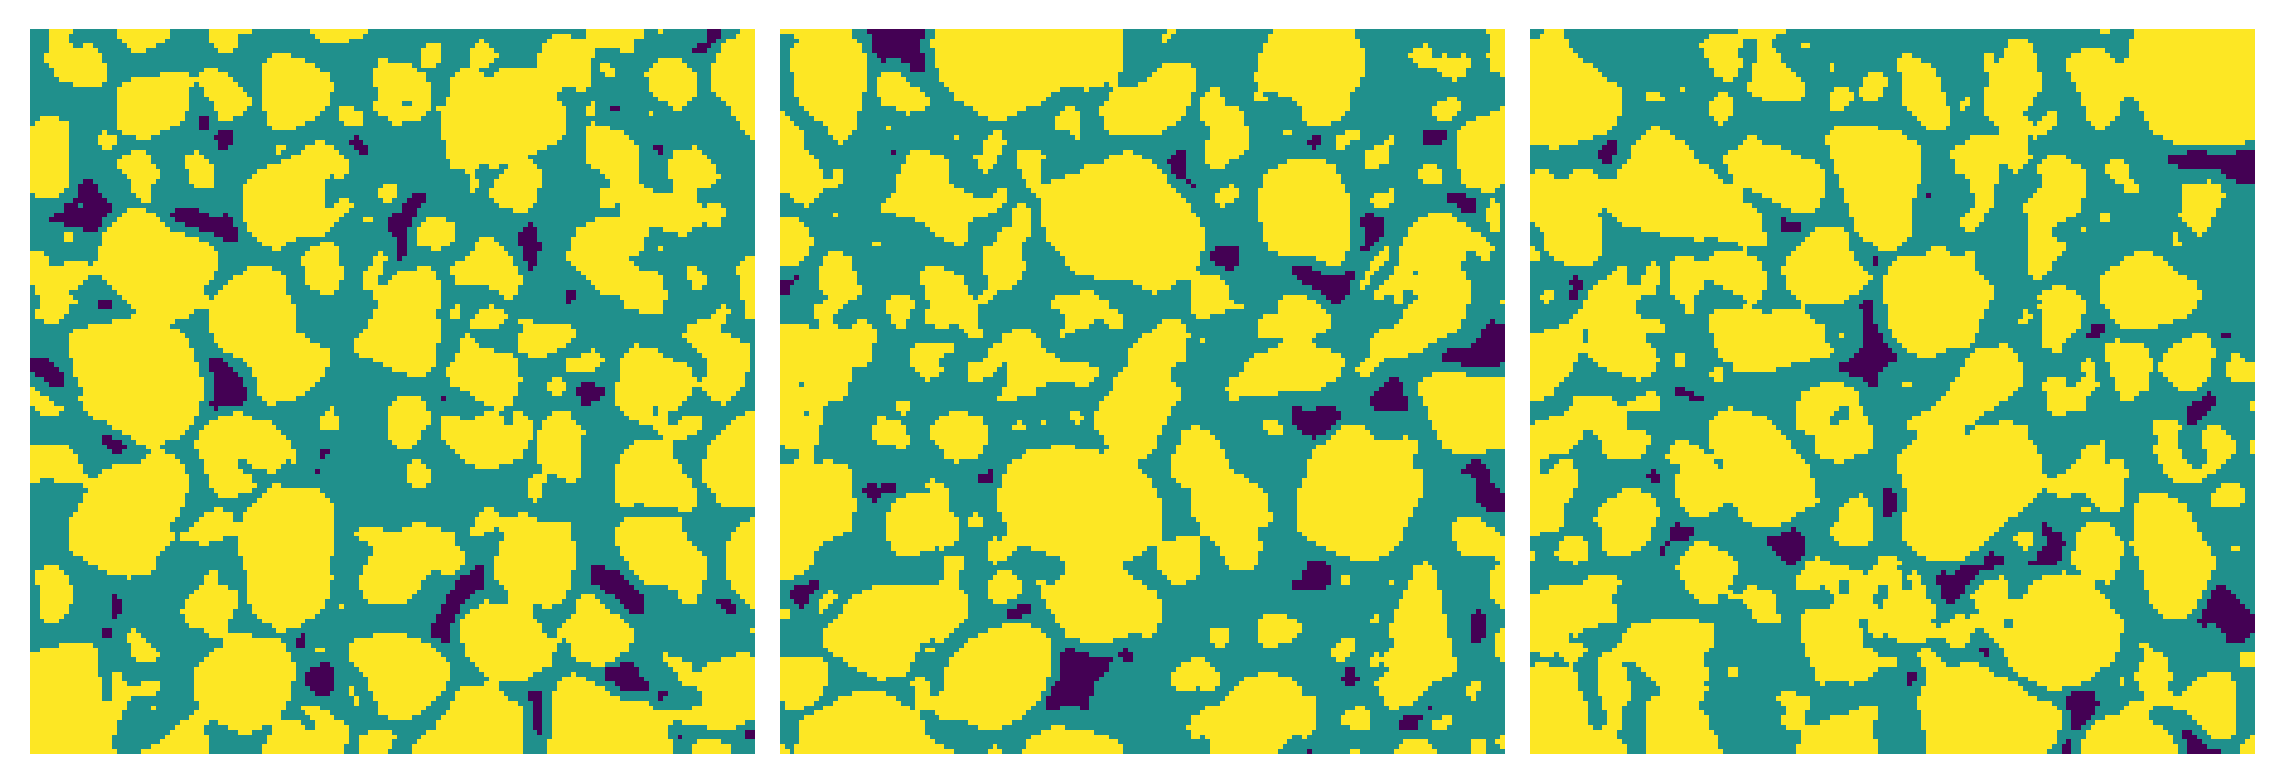

In [7]:
imgs_semantic = segment.isolate_classes(imgs_pre, mins)
n_vox_binder = (imgs_semantic == 1).sum()
print(f'{n_vox_binder=}')
n_vox_grains = (imgs_semantic == 2).sum()
print(f'{n_vox_grains=}')
n_vox_nonvoid = (imgs_semantic > 0).sum()
print(f'{n_vox_nonvoid=}')
fig, axes = view.plot_slices(imgs_semantic, slices=slices, dpi=300)
plt.show()

## Segment Data

Segmenting images...
--> Segmentation complete. 649 particle(s) segmented.


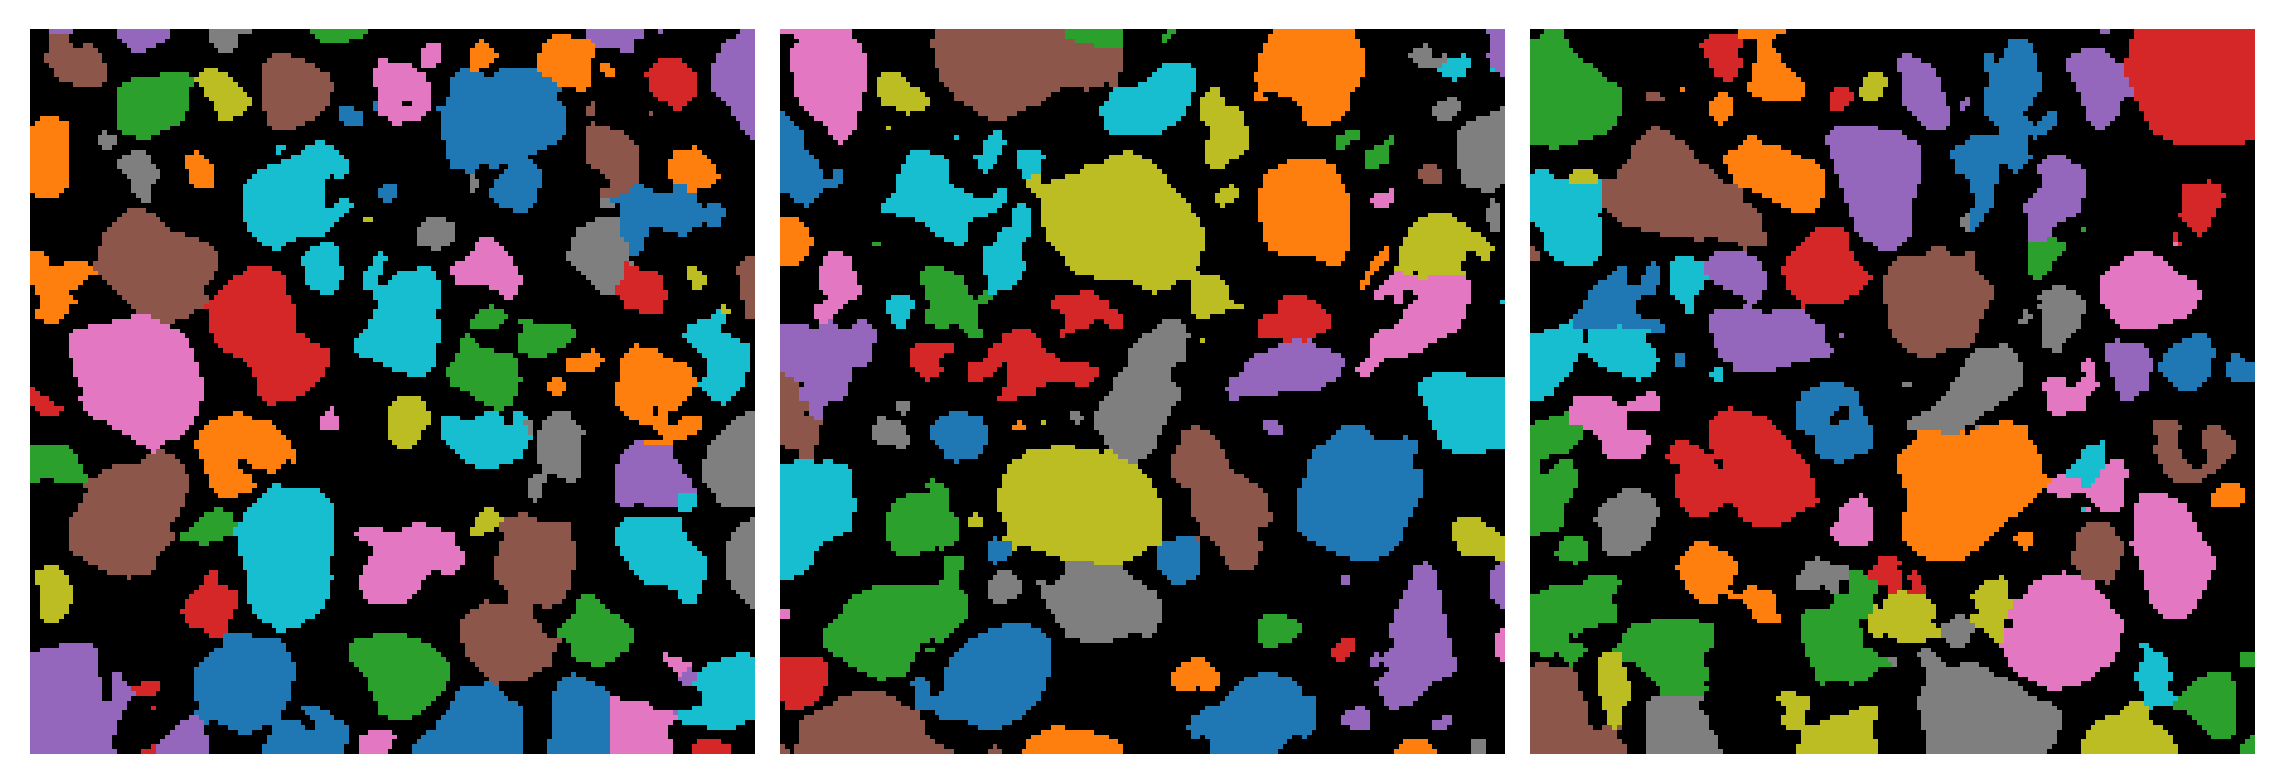

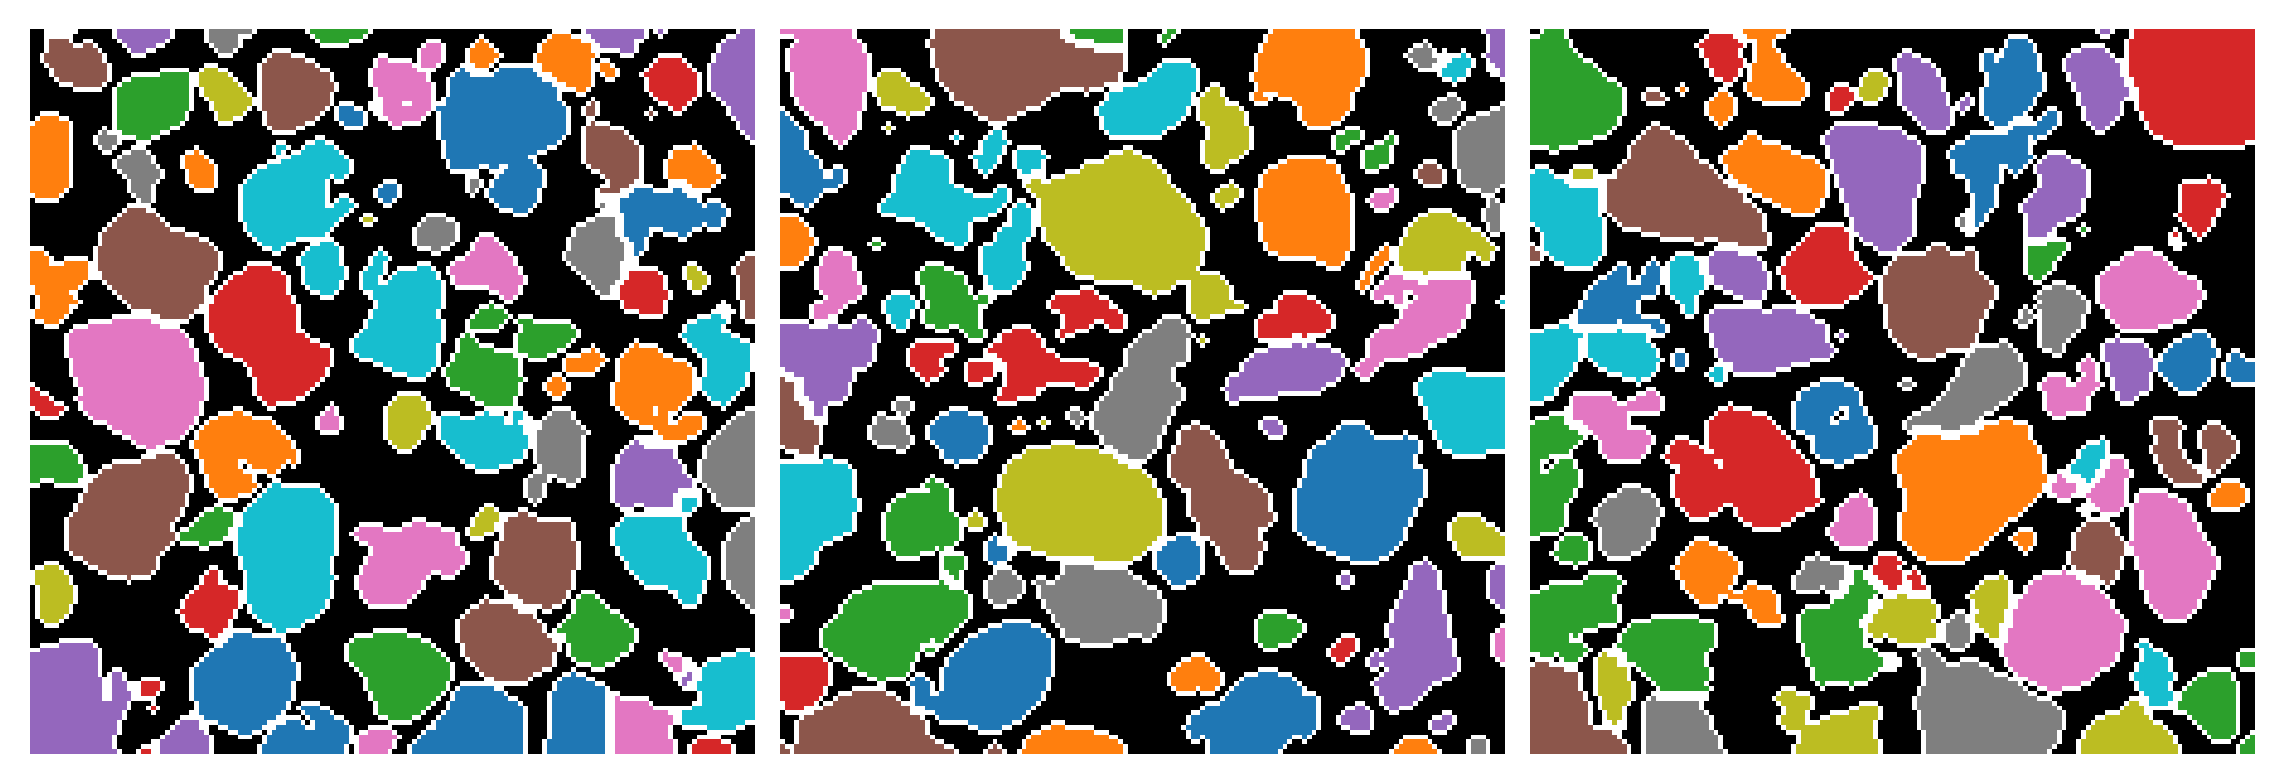

In [8]:
imgs_labeled = segment.watershed_segment(
    imgs_semantic == 2,
    min_peak_distance=6,
    return_dict=False
)
colors = view.get_colors(10, cmap=mpl.cm.tab10)
color_labels = [
    color.label2rgb(
        imgs_labeled[i, ...], bg_label=0, colors=colors
    ) for i in slices
]
fig, axes = view.plot_images(color_labels, dpi=300)
color_labels_outlined = [
    segmentation.mark_boundaries(
        color_labels[i], imgs_labeled[slice_i, ...], color=(1, 1, 1)
    ) for i, slice_i in enumerate(slices)
]
fig, axes = view.plot_images(color_labels_outlined, dpi=300)
plt.show()

### Single segmentation

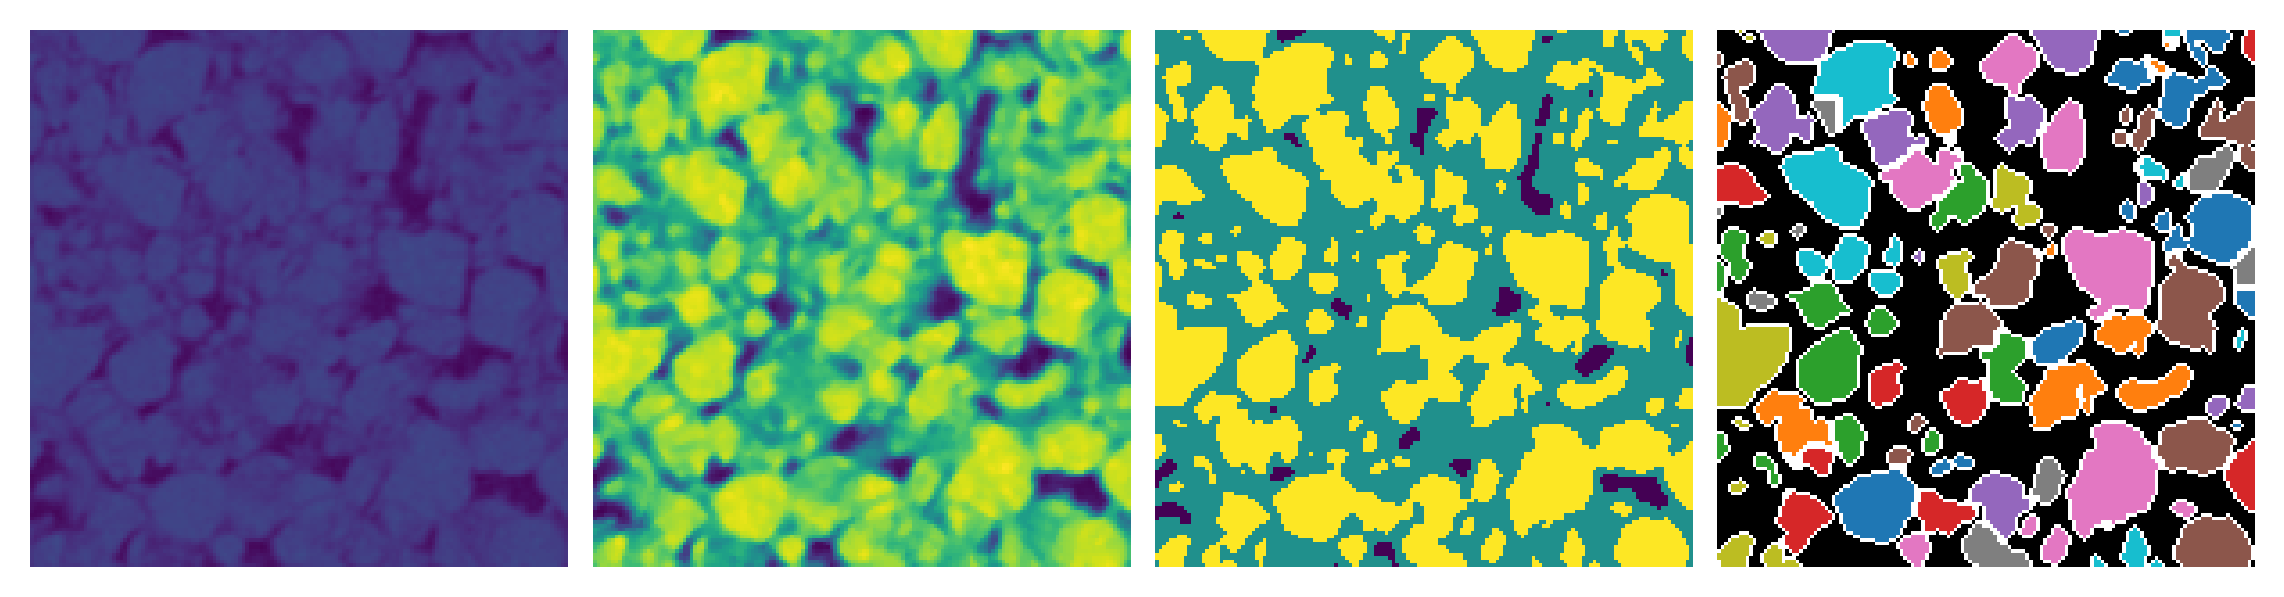

In [9]:
slice_i = 124
colors = view.get_colors(10, cmap=mpl.cm.tab10)
label_img = imgs_labeled[slice_i, ...]
labels_colored = (
    color.label2rgb(label_img, bg_label=0, colors=colors))
labels_colored = (
    segmentation.mark_boundaries(labels_colored, label_img, color=(1, 1, 1))
)
img_seq = [img[slice_i, ...] for img in [imgs, imgs_pre, imgs_semantic]]
img_seq.append(labels_colored)
fig, axes = view.plot_images(
    img_seq,
    vmin=(imgs.min(), None, None, None),
    vmax=(imgs.max(), None, None, None),
    dpi=300
)